In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('train.csv')
print(train_df.head().T)
test_df = pd.read_csv('test.csv')
print(test_df.head().T)

                                          0           1           2  \
Unnamed: 0                            36519       46845       46762   
DOT_ID_Reporting_Airline              20304       19977       20409   
Flight_Number_Reporting_Airline        4771        1937          46   
OriginAirportID                       11292       11298       12953   
OriginWac                                82          74          22   
DestAirportID                         11433       13930       15304   
DestWac                                  43          41          33   
CRSDepTime                             1720        1438        1115   
DepTime                              1758.0      1643.0      1139.0   
DepDelayMinutes                        38.0       125.0        24.0   
CRSArrTime                             2218        1659        1431   
ArrTime                              2305.0      1853.0      1453.0   
ArrDelayMinutes                        47.0       114.0        22.0   
Divert

In [ ]:
train_df.drop(columns=['Unnamed: 0', 'Year', 'Month', 'Day', 'Quarter', 'Week'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'Year', 'Month', 'Day', 'Quarter', 'Week'], inplace=True)
print(train_df.head())
print(test_df.head())

   DOT_ID_Reporting_Airline  Flight_Number_Reporting_Airline  OriginAirportID  \
0                     20304                             4771            11292   
1                     19977                             1937            11298   
2                     20409                               46            12953   
3                     19790                             1476            15304   
4                     20304                             3798            14869   

   OriginWac  DestAirportID  DestWac  CRSDepTime  DepTime  DepDelayMinutes  \
0         82          11433       43        1720   1758.0             38.0   
1         74          13930       41        1438   1643.0            125.0   
2         22          15304       33        1115   1139.0             24.0   
3         33          14492       36        1250   1311.0             21.0   
4         87          13486       84        2100   2100.0              0.0   

   CRSArrTime  ...  tavg  tmin  tmax  prcp  

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
# Function to train, predict, and evaluate each target column
def train_predict_evaluate(x_train, y_train, x_test, y_test, column_name):
    # Initialize the LightGBM Regressor
    lgb_regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42, force_col_wise=True)

    # Train the model on one target column at a time
    lgb_regressor.fit(x_train, y_train[column_name])

    # Predict
    y_pred = lgb_regressor.predict(x_test)

    # Evaluate
    mse = mean_squared_error(y_test[column_name], y_pred)
    r2 = r2_score(y_test[column_name], y_pred)

    print(f"Results for {column_name} - Mean Squared Error: {mse}, R^2 Score: {r2}")

    return pd.DataFrame(y_pred, columns=[column_name]), lgb_regressor

# Initializing x_train, y_train, x_test, and y_test for the first model
x_train = train_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted',
                         'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                         'LateAircraftDelay', 'CancellationCode_encoded', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir',
                         'wspd', 'pres'], axis=1)
y_train = train_df[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]

x_test = test_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted',
                       'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                       'LateAircraftDelay', 'CancellationCode_encoded', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir',
                       'wspd', 'pres'], axis=1)
y_test = test_df[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]

# Training on the first group of target columns
predicted_values = pd.DataFrame()
for column in y_train.columns:
    y_pred, model = train_predict_evaluate(x_train, y_train, x_test, y_test, column)
    predicted_values = pd.concat([predicted_values, y_pred], axis=1)

# Update x_train and x_test with predictions
x_train = pd.concat([x_train, y_train], axis=1)
x_test = pd.concat([x_test.reset_index(drop=True), predicted_values.reset_index(drop=True)], axis=1)


[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 12
[LightGBM] [Info] Start training from score 17.058483
Results for tavg - Mean Squared Error: 89.78507139819655, R^2 Score: -0.0018415528051376473
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 12
[LightGBM] [Info] Start training from score 12.068301
Results for tmin - Mean Squared Error: 88.31264708953569, R^2 Score: -0.010061992008462584
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 12
[LightGBM] [Info] Start training from score 22.356021
Results for tmax - Mean Squared Error: 99.16213168205695, R^2 Score: 0.009647269687446336
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 12
[LightGBM] [Info] Start training from score 2.489177
Resu

In [ ]:
# Repeat this process for the next set of target columns
y_train = train_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
                    'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]
y_test = test_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
                  'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]

predicted_values = pd.DataFrame()
for column in y_train.columns:
    y_pred, model = train_predict_evaluate(x_train, y_train, x_test, y_test, column)
    predicted_values = pd.concat([predicted_values, y_pred], axis=1)

# Update x_train and x_test with predictions
x_train = pd.concat([x_train, y_train], axis=1)
x_test = pd.concat([x_test.reset_index(drop=True), predicted_values.reset_index(drop=True)], axis=1)

[LightGBM] [Info] Total Bins 3800
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [ ]:
# Repeat for additional target columns
y_train = train_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]
y_test = test_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]

predicted_values = pd.DataFrame()
for column in y_train.columns:
    y_pred, model = train_predict_evaluate(x_train, y_train, x_test, y_test, column)
    predicted_values = pd.concat([predicted_values, y_pred], axis=1)

# Update x_train and x_test with predictions
x_train = pd.concat([x_train, y_train], axis=1)
x_test = pd.concat([x_test.reset_index(drop=True), predicted_values.reset_index(drop=True)], axis=1)

[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 26
[LightGBM] [Info] Start training from score 1523.631452
Results for DepTime - Mean Squared Error: 92934.63554642725, R^2 Score: 0.6383291604636792
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 26
[LightGBM] [Info] Start training from score 65.430381
Results for DepDelayMinutes - Mean Squared Error: 12006.248425980719, R^2 Score: -0.010412574281508657
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 26
[LightGBM] [Info] Start training from score 1533.382583
Results for ArrTime - Mean Squared Error: 209855.0342717517, R^2 Score: 0.5175121103188187


[LightGBM] [Info] Total Bins 6150
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 29
[LightGBM] [Info] Start training from score 68.452975
Results for ArrDelayMinutes - Mean Squared Error: 11370.912369382095, R^2 Score: 0.009396324264654088


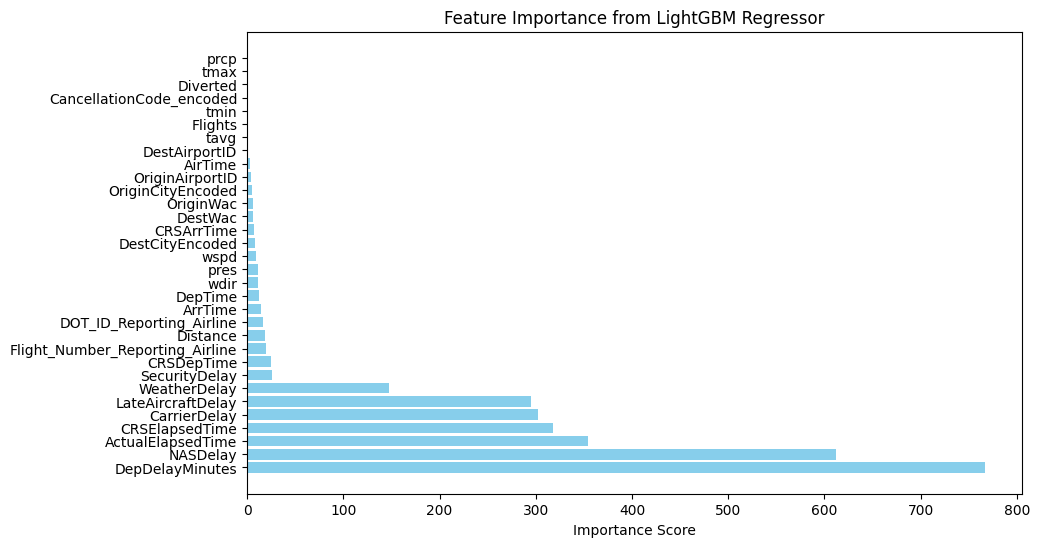

In [ ]:
# Final target
y_train = train_df[['ArrDelayMinutes']]
y_test = test_df[['ArrDelayMinutes']]

y_pred, model = train_predict_evaluate(x_train, y_train, x_test, y_test, 'ArrDelayMinutes')

# Feature Importance Plot
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from LightGBM Regressor')
plt.show()

In [ ]:
# Define your input and output data
y_train = train_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]
x_train = train_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'], axis=1)

y_test = test_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]
x_test = test_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'], axis=1)

# Initialize MultiOutputRegressor with LGBMRegressor
lgb_regressor = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42))
lgb_regressor.fit(x_train, y_train)

# Make predictions
y_pred = lgb_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print evaluation metrics for each target
for i, col in enumerate(y_train.columns):
    print(f"Target: {col}")
    print("Mean Squared Error:", mse[i])
    print("R^2 Score:", r2[i])
    print("\n")

# Convert predictions to DataFrame for next steps
y_pred = pd.DataFrame(y_pred, columns=['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'])

# Concatenate predictions to x_test for the next model stage
x_train = pd.concat([x_train, y_train], axis=1)
y_train = train_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]
x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3800
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirem

In [ ]:
# Train and evaluate model for the second stage
lgb_regressor = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42))
lgb_regressor.fit(x_train, y_train)
y_pred = lgb_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

for i, col in enumerate(y_train.columns):
    print(f"Target: {col}")
    print("Mean Squared Error:", mse[i])
    print("R^2 Score:", r2[i])
    print("\n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 26
[LightGBM] [Info] Start training from score 1523.631452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 26
[LightGBM] [Info] Start training from score 65.430381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 26
[LightGBM] [Info] Start

In [ ]:
# Repeat for next target
y_pred = pd.DataFrame(y_pred, columns=['DepTime', 'DepDelayMinutes', 'ArrTime'])
x_train = pd.concat([x_train, y_train], axis=1)
y_train = train_df[['ArrDelayMinutes']]
x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['ArrDelayMinutes']]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6150
[LightGBM] [Info] Number of data points in the train set: 82722, number of used features: 29
[LightGBM] [Info] Start training from score 68.452975
Final Target: ArrDelayMinutes
Mean Squared Error: 11375.24323621993
R^2 Score: 0.009019030651853721


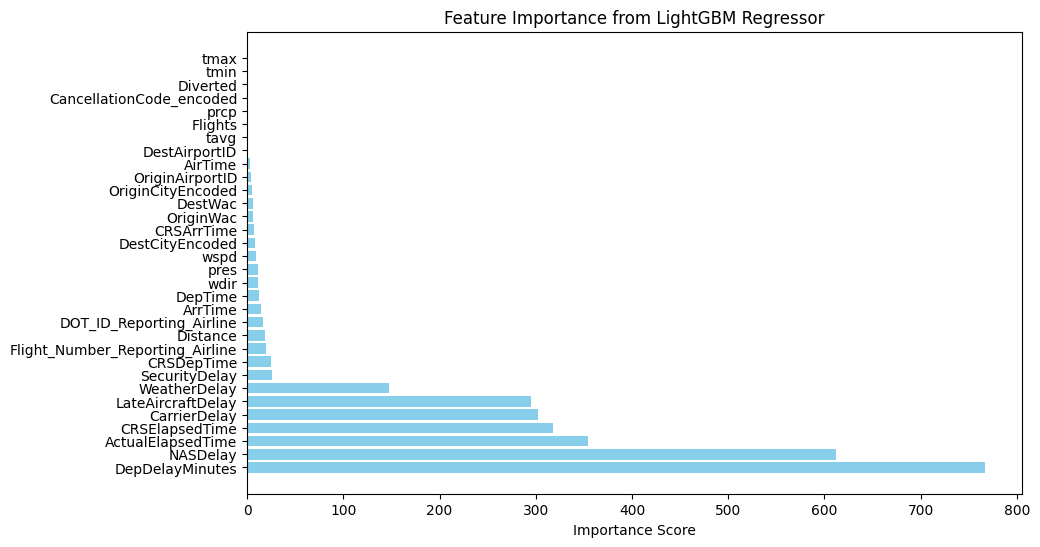

In [ ]:
# Train and evaluate the final model
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42)
lgb_regressor.fit(x_train, y_train)
y_pred = lgb_regressor.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final Target: ArrDelayMinutes")
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Feature importance for the final stage
importances = lgb_regressor.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from LightGBM Regressor')
plt.show()

In [ ]:
import xgboost as xgb

In [ ]:
y_train = train_df[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]
x_train = train_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'], axis = 1)
y_test = test_df[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]
x_test = test_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'], axis = 1)

xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)

# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

y_pred = pd.DataFrame(y_pred,  columns = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'])
x_train = pd.concat([x_train,y_train], axis = 1)
y_train = train_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]

x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]
xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)

Mean Squared Error: 1600.5150464036085
R^2 Score: -0.021215984597802162


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


y_pred = pd.DataFrame(y_pred,  columns = ['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'])
x_train = pd.concat([x_train,y_train], axis = 1)
y_train = train_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]

x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]
xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)

Mean Squared Error: 1482.018151399105
R^2 Score: 0.21865326166152954


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


y_pred = pd.DataFrame(y_pred,  columns = ['DepTime', 'DepDelayMinutes', 'ArrTime'])
x_train = pd.concat([x_train,y_train], axis = 1)
y_train = train_df[['ArrDelayMinutes']]

x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['ArrDelayMinutes']]

xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)

Mean Squared Error: 99012.97706899785
R^2 Score: 0.39501944184303284


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Mean Squared Error: 11544.570090853947
R^2 Score: -0.005732297897338867


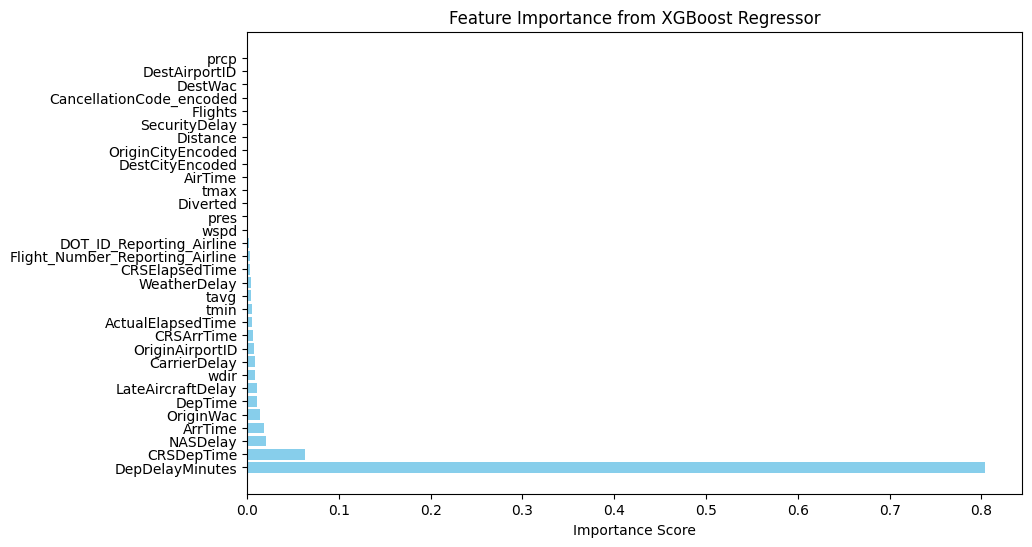

In [ ]:
# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
importances = xg_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from XGBoost Regressor')
plt.show()

In [ ]:
y_train = train_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]
x_train = train_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'], axis = 1)
y_test = test_df[['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded']]
x_test = test_df.drop(['DateObjects', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'], axis = 1)

xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)

# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

y_pred = pd.DataFrame(y_pred,  columns = ['Diverted', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode_encoded'])
x_train = pd.concat([x_train,y_train], axis = 1)
y_train = train_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]

x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['DepTime', 'DepDelayMinutes', 'ArrTime']]
xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)


Mean Squared Error: 1482.9420949590608
R^2 Score: 0.21481892466545105


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


y_pred = pd.DataFrame(y_pred,  columns = ['DepTime', 'DepDelayMinutes', 'ArrTime'])
x_train = pd.concat([x_train,y_train], axis = 1)
y_train = train_df[['ArrDelayMinutes']]

x_test = pd.concat([x_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
y_test = test_df[['ArrDelayMinutes']]
xg_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xg_regressor.fit(x_train, y_train)

Mean Squared Error: 98809.34194480302
R^2 Score: 0.39602819085121155


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred = xg_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 11524.15179362834
R^2 Score: -0.003953456878662109


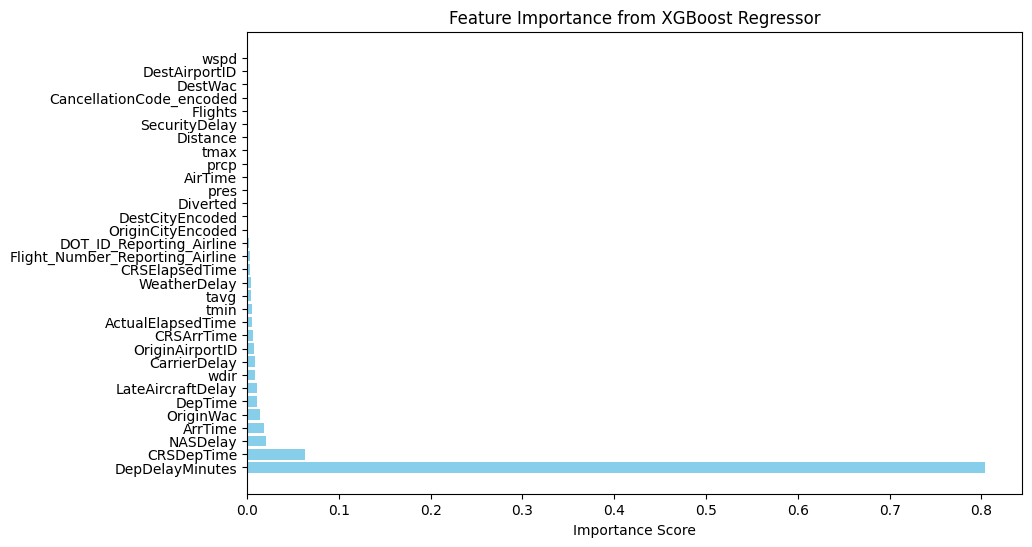

In [ ]:
importances = xg_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from XGBoost Regressor')
plt.show()